/home/hzheng/miniconda3/envs/adtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'AUC-PR': 0.093248787134401, 'AUC-ROC': 0.530103938073525, 'VUS-PR': 0.120638845443181, 'VUS-ROC': 0.6102478833869068, 'Standard-F1': 0.163800365777734, 'PA-F1': 0.9462068965517242, 'Event-based-F1': 0.21641791044776096, 'R-based-F1': 0.1579995648087087, 'Affiliation-F': 0.7301128847818936}


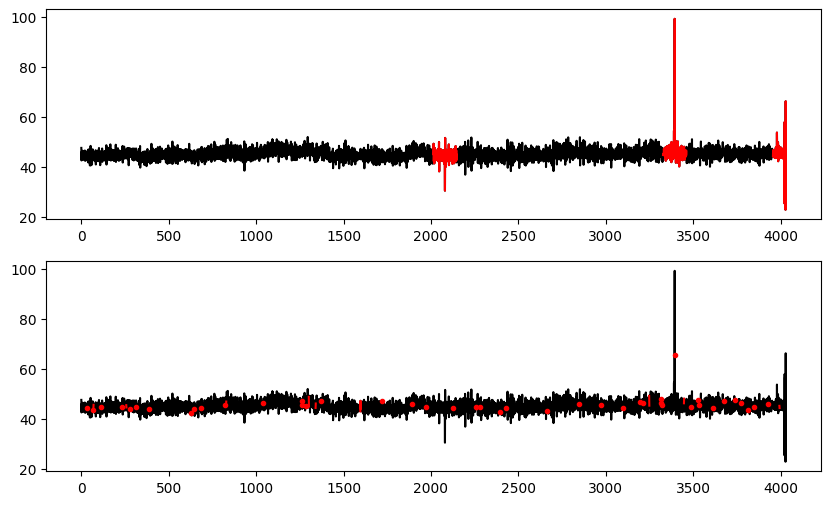

In [5]:
import pandas as pd
from TSB_AD.model_wrapper import run_Unsupervise_AD
from TSB_AD.evaluation.metrics import get_metrics
from TSB_AD.utils.dataAccess import *
import matplotlib.pyplot as plt
import numpy as np



# Specify Anomaly Detector to use and data directory
AD_Name = 'Sub_LOF'   # It can be replaced with any anomaly detector availale in TSB-AD
data_direc = 'Datasets/TSB-AD-U/001_NAB_id_1_Facility_tr_1007_1st_2014.csv'
# data_direc = 'Datasets/MyData/labeled_ucr/001_UCR_Anomaly_DISTORTED1sddb40tr_35000_1st_52000.csv'
# plotRange = (1500, 2500)

# Loading Data
df = pd.read_csv(data_direc).dropna()
data = df.iloc[:, 0:-1].values.astype(float) # 所有行，不包括最后一列（label）
label = df['Label'].astype(int).to_numpy()

# Applying Anomaly Detector, 这里会输出分数和打标
output = run_Unsupervise_AD(AD_Name, data)
# output = run_Semisupervise_AD(AD_Name, data, label)
# if output not a np Array, then it is not available in TSB-AD
if isinstance(output, np.ndarray):
    output_label = np.zeros(len(output))
    for i in range(len(output)):
        if output[i] > 0.6:
            output_label[i] = 1

    # Evaluation 这里是算评价指标，对比label
    evaluation_result = get_metrics(output, label)
    print(evaluation_result)

    prefix, test_loc, ab_l = parseDataFile(data_direc)

    range_anomaly = range_convers_new(label)
    range_predict_anomaly = range_convers_new(output_label)

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    ax[0].plot(data, 'k')
    ax[1].plot(data, 'k')

    for r in range_anomaly:
        if r[0]==r[1]:
            ax[0].plot(r[0],data[r[0]],'r.')
        else:
            ax[0].plot(range(r[0],r[1]+1),data[range(r[0],r[1]+1)],'r')
            
    for r in range_predict_anomaly:
        if r[0]==r[1]:
            ax[1].plot(r[0],data[r[0]],'r.')
        else:
            ax[1].plot(range(r[0],r[1]+1),data[range(r[0],r[1]+1)],'r')
            
    # xlim 
    # ax[0].set_xlim(plotRange)
    # ax[1].set_xlim(plotRange)
else:
    print('Anomaly Detector is not available in TSB-AD')
    print('Output:', output)